Epoch [1/10], Train Acc: 93.17%, Val Acc: 97.68%
Epoch [2/10], Train Acc: 97.79%, Val Acc: 97.67%
Epoch [3/10], Train Acc: 98.31%, Val Acc: 98.75%
Epoch [4/10], Train Acc: 98.56%, Val Acc: 98.65%
Epoch [5/10], Train Acc: 98.79%, Val Acc: 98.72%
Epoch [6/10], Train Acc: 98.78%, Val Acc: 98.75%
Epoch [7/10], Train Acc: 98.99%, Val Acc: 99.13%
Epoch [8/10], Train Acc: 99.05%, Val Acc: 99.15%
Epoch [9/10], Train Acc: 99.10%, Val Acc: 99.08%
Epoch [10/10], Train Acc: 99.01%, Val Acc: 98.73%

✅ Final Test Accuracy on QMNIST: 98.94%


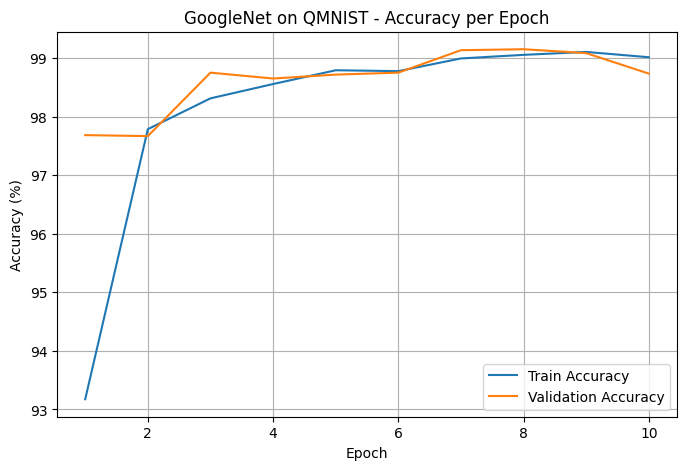

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.models import googlenet

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# QMNIST dataset (32x32 grayscale converted to 3-channel RGB)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
full_dataset = torchvision.datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into train and validation sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load GoogleNet and adjust final layer
model = googlenet(num_classes=10, aux_logits=False)
model = model.to(device)

# Custom He + Orthogonal initialization
def custom_init(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

custom_init(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 10
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_acc_list.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

# Test accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'\n✅ Final Test Accuracy on QMNIST: {test_accuracy:.2f}%')

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('GoogleNet on QMNIST - Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()
